# Deep Learning Final Project - Predicicting Second Order Products Using Deep Learning

##### Import Data

In [17]:
import pandas as pd

data = pd.read_csv('order_data.csv')

### Exploratory Data Analysis

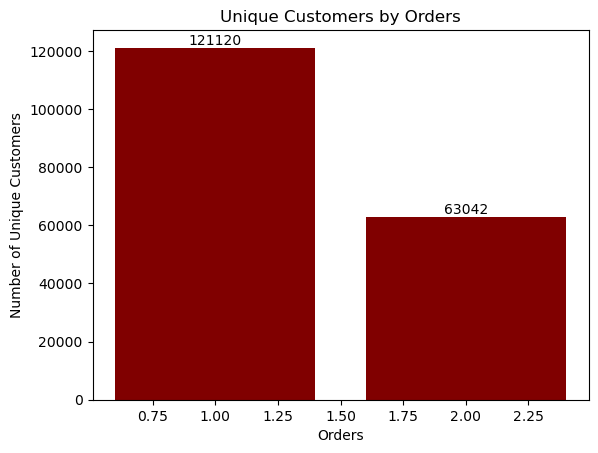

In [2]:
import matplotlib.pyplot as plt

# Group by ORDER_RANK and count unique CUST_IDs
counts_by_order_rank = data.groupby('ORDER_RANK')['CUST_ID'].nunique()

# Create bar chart
plt.bar(counts_by_order_rank.index, counts_by_order_rank.values, color = '#800000')

# Add labels and title
plt.xlabel('Orders')
plt.ylabel('Number of Unique Customers')
plt.title('Unique Customers by Orders')
# Annotate each bar with the count value
for i, count in enumerate(counts_by_order_rank.values):
    plt.text(counts_by_order_rank.index[i], count + 0.1, str(count), ha='center', va='bottom')


# Display the plot
plt.show()

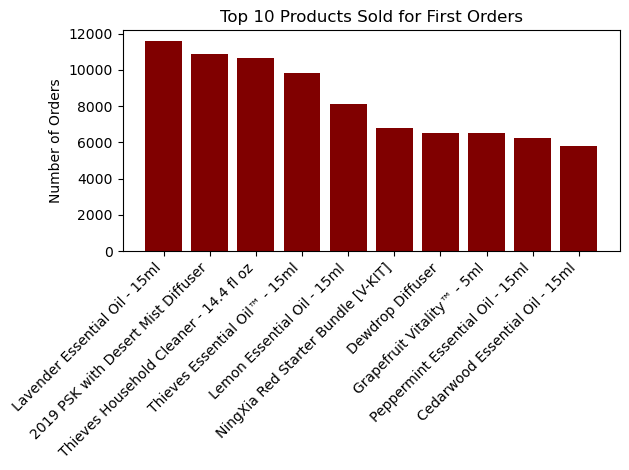

In [3]:
# Filter to include only first orders (ORDER_RANK == 1)
first_orders = data[data['ORDER_RANK'] == 1]

# Count occurrences of each product in first orders
product_counts = first_orders['PRODUCT_NAME'].value_counts()

# Select top 10 products
top_10_products = product_counts.head(10)

# Create bar chart for top 10 products
plt.bar(top_10_products.index, top_10_products.values, color='#800000')

# Add labels and title
#plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.title('Top 10 Products Sold for First Orders')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

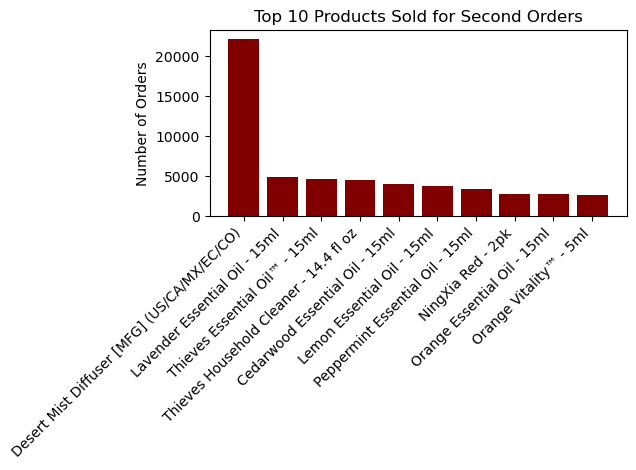

In [4]:
# Filter to include only first orders (ORDER_RANK == 1)
second_orders = data[data['ORDER_RANK'] == 2]

# Count occurrences of each product in first orders
product_counts = second_orders['PRODUCT_NAME'].value_counts()

# Select top 10 products
top_10_products = product_counts.head(10)

# Create bar chart for top 10 products
plt.bar(top_10_products.index, top_10_products.values, color='#800000')

# Add labels and title
#plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.title('Top 10 Products Sold for Second Orders')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

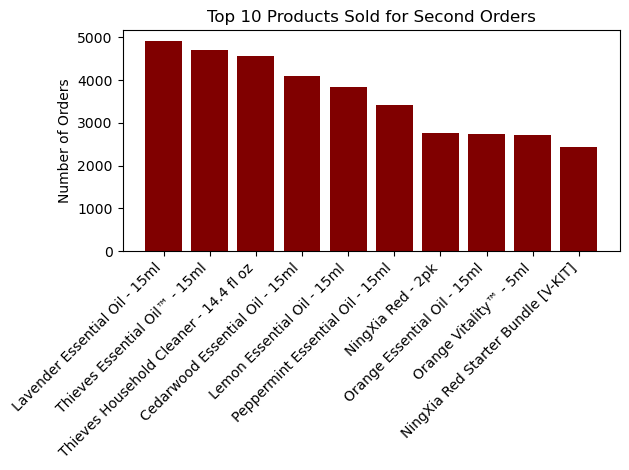

In [5]:
# Drop Desert Mist Diffuser (20200) to remove the outlier product and reduce noise
filtered_df = data[data['PART_NUMBER'] != '20200']
filtered_df.head()

# Filter to include only first orders (ORDER_RANK == 1)
second_orders = filtered_df[filtered_df['ORDER_RANK'] == 2]

# Count occurrences of each product in first orders
product_counts = second_orders['PRODUCT_NAME'].value_counts()

# Select top 10 products
top_10_products = product_counts.head(10)

# Create bar chart for top 10 products
plt.bar(top_10_products.index, top_10_products.values, color='#800000')

# Add labels and title
#plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.title('Top 10 Products Sold for Second Orders')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### Data Processing for LSTM

In [6]:
#Data Processing

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Encode part numbers as not all integers
encoder = LabelEncoder()
filtered_df['encoded_part_number'] = encoder.fit_transform(filtered_df['PART_NUMBER'])


# GROUP BY CUST_ID AND ORDER_RANK
filtered_df['ORDER_PAID_DATE'] = pd.to_datetime(filtered_df['ORDER_PAID_DATE'])
data_sorted = filtered_df.sort_values(by=['CUST_ID', 'ORDER_PAID_DATE'])
grouped_data = data_sorted.groupby(['CUST_ID', 'ORDER_RANK'])['encoded_part_number'].apply(list)

sequences = pad_sequences(grouped_data, maxlen = 5, padding = 'pre')
X = sequences[:, :-1]
y = sequences[:, -1]

# Split into test and train 
from sklearn.model_selection import train_test_split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

/var/folders/g4/67myv6ld5mnd2mmg2jzxfpj40000gn/T/ipykernel_48026/3518387927.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_part_number'] = encoder.fit_transform(filtered_df['PART_NUMBER'])
/var/folders/g4/67myv6ld5mnd2mmg2jzxfpj40000gn/T/ipykernel_48026/3518387927.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ORDER_PAID_DATE'] = pd.to_datetime(filtered_df['ORDER_PAID_DATE'])


### LSTM MODEL

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

# Number of unique products
num_products = len(encoder.classes_)

model_LSTM = Sequential([
    Embedding(input_dim=num_products, output_dim=50),
    LSTM(100),
    Dense(num_products, activation='softmax')
])

model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_LSTM.summary())

model_LSTM.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)

loss, accuracy = model_LSTM.evaluate(X_test_lstm, y_test_lstm)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss}")

loss, accuracy = model_LSTM.evaluate(X_train_lstm, y_train_lstm)
print(f"Train Accuracy: {accuracy*100:.2f}%")
print(f"Train Loss: {loss}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.0546 - loss: 5.4263
Epoch 2/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.0903 - loss: 4.9275
Epoch 3/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.1090 - loss: 4.7666
Epoch 4/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.1242 - loss: 4.6479
Epoch 5/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.1311 - loss: 4.5823
Epoch 6/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.1376 - loss: 4.5122
Epoch 7/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.1439 - loss: 4.4568
Epoch 8/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.1478 - loss: 4.4130
Epoch 9/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.1546 - loss: 4.3578
Epoch 10/10
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.1575 - loss: 4.3230
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1327 - loss: 4.7363
Test Accuracy: 13.28%
Test 

### CNN with Categorical Crossentropy Model

##### DATA PROCESSING

In [8]:
# Group data by customer and order rank to structure sequences
grouped = filtered_df.sort_values(by=['CUST_ID', 'ORDER_RANK']).groupby(['CUST_ID', 'ORDER_RANK'])
print("Type of grouped", type(grouped))
print(grouped.head())

# Prepare sequences where each first order predicts the second order
sequences = {}
for (cust_id, order_rank), group in grouped:
    if order_rank == 1:
        sequences[cust_id] = {'input': group['PART_NUMBER'].tolist()}
    elif order_rank == 2 and cust_id in sequences:
        sequences[cust_id]['output'] = group['PART_NUMBER'].tolist()

# Filter out incomplete sequences
sequences = {k: v for k, v in sequences.items() if 'output' in v}

# Convert sequences to a suitable format (e.g., one-hot encoding or simple numerical index if already integers)
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
all_parts = [part for seq in sequences.values() for part in seq['input'] + seq['output']]
tokenizer.fit_on_texts(all_parts)  # Assuming PART_NUMBERs are strings; if not, adjust accordingly

# Encode sequences
for cust_id, seq in sequences.items():
    seq['input'] = tokenizer.texts_to_sequences([seq['input']])[0]
    seq['output'] = tokenizer.texts_to_sequences([seq['output']])[0]

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Decide on a maximum sequence length
#max_sequence_length = 10  # You can set this based on the distribution of your data

# Pad sequences
X_padded = pad_sequences([seq['input'] for seq in sequences.values()], maxlen=1604, padding='post', truncating='post')
y_padded = pad_sequences([seq['output'] for seq in sequences.values()], maxlen=1604, padding='post', truncating='post')

# Reshape for CNN input - assuming we keep one channel dimension
X_padded = X_padded.reshape((X_padded.shape[0], 1, X_padded.shape[1]))

# Split into test and train 
from sklearn.model_selection import train_test_split
X_train_cnn1, X_test_cnn1, y_train_cnn1, y_test_cnn1 = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42, shuffle=True)

Type of grouped <class 'pandas.core.groupby.generic.DataFrameGroupBy'>
         CUST_ID   ORDER_ID           ORDER_PAID_DATE  ORDER_RANK PART_NUMBER  \
291105    537256    4171364 2002-03-05 10:40:56+00:00           1        9038   
122057    537256  191729911 2023-03-03 11:02:04+00:00           2        3300   
122060    537256  191729911 2023-03-03 11:02:04+00:00           2       37319   
122061    537256  191729911 2023-03-03 11:02:04+00:00           2        3548   
206481    537256  191729911 2023-03-03 11:02:04+00:00           2        3377   
...          ...        ...                       ...         ...         ...   
287502  39294986  200702639 2023-12-20 21:50:39+00:00           1     334976P   
371526  39294986  200702639 2023-12-20 21:50:39+00:00           1       41241   
371527  39294986  200702639 2023-12-20 21:50:39+00:00           1      324376   
34185   39294986  201336505 2024-01-12 23:06:02+00:00           2       46570   
202932  39294986  201336505 2024-01-12

##### CNN Categorical Crossentropy Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model_CNN1 = Sequential([
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, padding='same'),
    Flatten(),
    #Dense(100, activation='relu'),
    Dense(1604, activation='softmax')
])

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=0.00001, clipnorm=1)  # Clipnorm can be set to a value like 1.0

# Compile the model with the new optimizer
model_CNN1.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_CNN1.fit(X_train_cnn1, y_train_cnn1, epochs=2, batch_size=32)

loss, accuracy = model_CNN1.evaluate(X_test_cnn1, y_test_cnn1)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss}")
loss, accuracy = model_CNN1.evaluate(X_train_cnn1, y_train_cnn1)
print(f"Train Accuracy: {accuracy*100:.2f}%")
print(f"Train Loss: {loss}")


Epoch 1/2
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0456 - loss: 3240.9866
Epoch 2/2
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2054 - loss: 3641.2314
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.2030 - loss: 10940.9473
Test Accuracy: 20.75%
Test Loss: 7244.51904296875
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.2058 - loss: 6011.0894
Train Accuracy: 20.66%
Train Loss: 5908.396484375


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model_CNN2 = Sequential([
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, padding='same'),
    Flatten(),
    #Dense(100, activation='relu'),
    Dense(1604, activation='softmax')  # Ensure num_classes matches your output shape expectations
])

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=0.00001, clipnorm=0.5)  # Clipnorm can be set to a value like 1.0

# Compile the model with the new optimizer
model_CNN2.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_CNN2.fit(X_train_cnn1, y_train_cnn1, epochs=10, batch_size=128)

loss, accuracy = model_CNN2.evaluate(X_test_cnn1, y_test_cnn1)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss}")
loss, accuracy = model_CNN2.evaluate(X_train_cnn1, y_train_cnn1)
print(f"Train Accuracy: {accuracy*100:.2f}%")
print(f"Train Loss: {loss}")


Epoch 1/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0033 - loss: 3686.1907
Epoch 2/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2525 - loss: 3136.0669
Epoch 3/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5459 - loss: 3449.4927
Epoch 4/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5434 - loss: 3946.6353
Epoch 5/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5493 - loss: 4960.1919
Epoch 6/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5447 - loss: 5615.1470
Epoch 7/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5448 - loss: 7038.1543
Epoch 8/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5462 - loss: 7721.6943
Epoch 9/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5475 - loss: 9101.6826
Epoch 10/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5465 - loss: 10176.3770
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.5512 - loss: 20848.9648
Test Accuracy: 54.50%
Test 

### CNN using Binary Crossentropy

In [11]:
# Filter customers with first order
first_order_customers = filtered_df[filtered_df['ORDER_RANK'] == 1]['CUST_ID'].unique()

# Filter customers with second order
second_order_customers = filtered_df[filtered_df['ORDER_RANK'] == 2]['CUST_ID'].unique()

# Find customers who have both a first and a second order
customers_with_both_orders = set(first_order_customers).intersection(second_order_customers)

# Filter original data to only include these customers
filtered_data = filtered_df[filtered_df['CUST_ID'].isin(customers_with_both_orders)]

filtered_data.head()

# GROUP orders by customer and order rank
grouped = filtered_data.groupby(['CUST_ID', 'ORDER_RANK'])['PART_NUMBER'].apply(list).unstack()

# Convert part numbers to a format suitable for training (e.g., binary encoding)
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(grouped[1])  # First orders
y = mlb.transform(grouped[2])      # Second orders

# Split into test and train 
from sklearn.model_selection import train_test_split
X_train_cnn2, X_test_cnn2, y_train_cnn2, y_test_cnn2 = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_reshaped = X_train_cnn2.reshape((-1, X_train_cnn2.shape[1], 1))
X_reshaped_test = X_test_cnn2.reshape((-1, X_train_cnn2.shape[1], 1))

/Users/Kate/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['1000S', '1097', '1098', '19329', '19971', '200656R', '20149', '20177', '20200P', '20667', '20784', '20798', '20825', '21397', '21751', '21835', '21933', '21980', '220115', '220115R', '220131', '220173', '22170', '23141', '23685', '24468', '24557P', '24725', '25188', '25199', '25202', '25203', '25265', '25312', '25612', '25765', '25862R', '25931', '26769R', '26967', '27258', '27740R', '27976P', '28264R', '28391', '28704P', '28995', '29605', '29962R', '30086R', '30191R', '302615', '303303', '3033515', '3040R', '3042515', '3042515P', '3042560', '3042R', '3052', '305515', '30557', '305911', '306011', '307405', '308305', '309103', '30942', '31131', '313746', '3137531', '32000', '32048', '32101P', '32142', '321429', '32163', '322215', '324015', '324029', '32412R', '32413R', '32414R', '324215', '324229', '3242P', '324329', '3244', '326503', '3265P', '330011', '3315P', '3322

In [12]:

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
model_CNN3 = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1299, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam, Nadam

model_CNN3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Reshape X to fit the model's expected input


model_CNN3.fit(X_reshaped, y_train_cnn2, epochs=5, batch_size=32)

loss, accuracy = model_CNN3.evaluate(X_reshaped_test, y_test_cnn2)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss}")

loss, accuracy = model_CNN3.evaluate(X_reshaped, y_train_cnn2)
print(f"Train Accuracy: {accuracy*100:.2f}%")
print(f"Train Loss: {loss}")

Epoch 1/5
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.0295 - loss: 0.1225
Epoch 2/5
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - accuracy: 0.1304 - loss: 0.0144
Epoch 3/5
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - accuracy: 0.1680 - loss: 0.0132
Epoch 4/5
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.1881 - loss: 0.0126
Epoch 5/5
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.1965 - loss: 0.0122
394/394 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1628 - loss: 0.0178
Test Accuracy: 16.51%
Test Loss: 0.017608163878321648
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 459s 291ms/step - accuracy: 0.1726 - loss: 0.0170
Train Accuracy: 17.03%
Train Loss: 0.016996843740344048


### Confusion Matrices and Classification Report

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

predictions = model_CNN2.predict(X_test_cnn1)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_test_cnn1.argmax(axis=1)

print("Classification report for model_CNN2\n ", classification_report(true_classes, predicted_classes))


394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
Classification report for model_CNN2
                precision    recall  f1-score   support

           0       0.54      1.00      0.71      6864
           1       0.00      0.00      0.00      2614
           2       0.00      0.00      0.00      1207
           3       0.00      0.00      0.00       683
           4       0.00      0.00      0.00       408
           5       0.00      0.00      0.00       294
           6       0.00      0.00      0.00       159
           7       0.00      0.00      0.00       106
           8       0.00      0.00      0.00        67
           9       0.00      0.00      0.00        55
          10       0.00      0.00      0.00        42
          11       0.00      0.00      0.00        30
          12       0.00      0.00      0.00        22
          13       0.00      0.00      0.00        13
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00        10

/Users/Kate/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Kate/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Kate/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

predictions = model_CNN3.predict(X_test_cnn2)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_test_cnn2.argmax(axis=1)

print("Classification report for model_CNN3\n ", classification_report(true_classes, predicted_classes))


394/394 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Classification report for model_CNN3
                precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.64      0.13      0.21       270
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00        14
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00        10
          18       0.50      0.12      0.19        17
          20       0.00      0.00      0.00        12


/Users/Kate/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Kate/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Kate/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Kate/anaconda3/li

### Recommender: 

In [16]:
def recommend_products(first_order):
    # Encode the first order products using the tokenizer
    first_order_encoded = tokenizer.texts_to_sequences([first_order])[0]
    
    # Pad the sequence
    first_order_encoded = pad_sequences([first_order_encoded], maxlen=1604, padding='post', truncating='post')
    
    # Reshape to match the input shape expected by the model
    first_order_encoded = first_order_encoded.reshape((1, 1, 1604))
    
    # Make predictions using the CNN model
    predictions = model_CNN2.predict(first_order_encoded)[0]
    
    # Get the top 5 product indices
    top_indices = predictions.argsort()[-5:][::-1]
    
    # Decode the top indices to product numbers
    inverse_tokenizer = {v: k for k, v in tokenizer.word_index.items()}
    top_products = [inverse_tokenizer[idx] for idx in top_indices if idx in inverse_tokenizer]
    
    # Display the top 5 predicted products
    print("Top 5 recommended products:", top_products)
    return top_products

# Example usage
first_order_example = ['43230', '3503']
recommended_products = recommend_products(first_order_example)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Top 5 recommended products: ['3423', '26669', '3575', '42763']
